In [1]:
#!pip install seaborn

In [2]:
import json
import glob
import pprint

import numpy as np
import pandas as pd

from itertools import groupby
from anytree import PreOrderIter
from anytree.search import findall
from comorbid_graphs import ComorbidGraph, ComorbidGraphNode

## Get Analysed Data

In [4]:
annotations = glob.glob('../examples/ontologies/mental_health/annotations/*')
annotations

['../examples/ontologies/mental_health/annotations/representation_MF-core.json',
 '../examples/ontologies/mental_health/annotations/syndrome_ND.json',
 '../examples/ontologies/mental_health/annotations/general symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/bodily disposition_MF-core.json',
 '../examples/ontologies/mental_health/annotations/neurological disease_ND.json',
 '../examples/ontologies/mental_health/annotations/neurological and physiological symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/head and neck symptom_symp.json',
 '../examples/ontologies/mental_health/annotations/interpersonal process_MF-core.json',
 '../examples/ontologies/mental_health/annotations/disease of mental health_HumanDO.json',
 '../examples/ontologies/mental_health/annotations/pathological bodily process_ND.json',
 '../examples/ontologies/mental_health/annotations/mental disorder_MD-core.json',
 '../examples/ontologies/mental_health/annotations/consciousness_M

### DSM-V Data

In [5]:
%%time
data_file = '../examples/dsm_v/dsm_v.json'
analysis_files = [
    '../examples/dsm_v/dsm_v.json',
    *annotations
]
#generate_test_data(data_file, analysis_files)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 15.7 µs


In [6]:
cg = open_existing_data(data_file)
print(cg.explore(maxlevel=2))

dsm-v
├── Neurodevelopmental Disorders
├── Schizophrenia Spectrum and Other Psychotic Disorders
├── Bipolar and Related Disorders
├── Depressive Disorders
├── Anxiety Disorders
├── Obsessive-Compulsive and Related Disorders
├── Trauma and Stressor-Related Disorders
├── Dissociative Disorders
├── Somatic Symptom and Related Disorders
├── Feeding and Eating Disorders
├── Elimination Disorders
├── Sleep-Wake Disorders
├── Sexual Dysfunctions
├── Gender Dysplioria
├── Disruptive, Impulse-Control, and Conduct Disorders
├── Substance-Related and Addictive Disorders
├── Neurocognitive Disorders
├── Personality Disorders
├── Paraphilic Disorders
├── Other Mental Disorders
├── Medication-Induced Movement Disorders and Other Adverse Effects of Medication
└── Other Conditions That May Be a Focus of Clinicai Attention



In [7]:
nonempty = [i for i in cg.get_nodes() if len(i.annotation_list) > 0]
len(nonempty)

1615

In [8]:
nonempty[-3].body

'Functionai Consequences of \nTypical impairments associated with fetishistic disorder include sexual dysfunction \nduring romantic reciprocal relationships when the preferred fetish object or body part is\n\n\n\nunavailable during foreplay or coitus. Some individuals with fetishistic disorder may pre\xad\nfer solitary sexual activity associated with their fetishistic preference(s) even while in\xad\nvolved in a meaningful reciprocal and affectionate relationship.\n\nAlthough fetishistic disorder is relatively uncommon among arrested sexual offenders \nwith paraphilias, males with fetishistic disorder may steal and collect their particular fe\xad\ntishistic objects of desire. Such individuals have been arrested and charged for nonsexual \nantisocial behaviors (e.g., breaking and entering, theft, burglary) that are primarily moti\xad\nvated by the fetishistic disorder.\n'

### Create Labels Table

In [13]:
# create dataframe
df = pd.DataFrame([
    {
        "node":i.name,
        **pivot_group(i.annotation_list, 'ancestor'),
        #**pivot_group(i.annotation_list, 'parent'),
    }
    for i in cg.get_nodes()
    if i.annotation_list != [] and not (not filter_out_sections and i.type and i.type == 'section')
]).replace({np.nan: set()})
if len(df):
    df.set_index('node', inplace=True)

# per node shared labels
df['all'] = df.apply(union_series, axis=1)
df['common'] = df.iloc[:,:-1].apply(intersect_series, axis=1)

# per analysis category 
shared = {}
for name, values in df.iteritems():
    shared[name] = union_series(values)
shared['node'] = 'total'
df = df.append(pd.DataFrame([shared]).set_index('node'))
return df

### Get crossovers

In [10]:
df = create_nodes_labels_table(cg)
df.head(5)

,dsm_v,disease stage_ND,syndrome_ND,mental process_MF-core,bodily disposition_MF-core,interpersonal process_MF-core,disease of mental health_HumanDO,general symptom_symp,nervous system symptom_symp,pathological mental process_MD-core,disorder_ND,nervous system disease_HumanDO,pathological bodily process_ND,neurological disease_ND,head and neck symptom_symp,neurological and physiological symptom_symp,mental disorder_MD-core,all,common
node,,,,,,,,,,,,,,,,,,,
Intellectual Disability,"{Unspecified Communication Disorder, Language ...",{onset},{ND_0003015},{hearing},{personality},{communication},{stuttering},{weakness},{irritability},{hyperactivity},{injury},{cerebral palsy},{seizure},{infantile spasms},{deafness},{},{},"{ND_0003015, stuttering, hyperactivity, cerebr...",{}
Language Disorder,"{Speech Sound Disorder, Language Disorder}",{onset},{ND_0003015},{hearing},{},{communication},"{communication disorder, developmental coordin...",{},{},{regression},{neurological disorder},{},{seizure},{},{},{},{},"{ND_0003015, communication, onset, Language Di...",{}
Speech Sound Disorder,{Selective Mutism},{onset},{ND_0003015},{hearing},{},{communication},{stuttering},{},{incoordination},{},{injury},{},{},{},{deafness},{anxiety},{},"{anxiety, ND_0003015, stuttering, communicatio...",{}
Childhood-Onset Fluency Disorder (Stuttering),{Differential Diagnosis},{onset},{ND_0003015},{hearing},{},{communication},{communication disorder},{tremor},{},{},{stroke},{},{},{},{},{anxiety},{},"{anxiety, ND_0003015, communication, onset, he...",{}
Social (Pragmatic) Communication Disorder,{Autism Spectrum Disorder},{onset},{ND_0003015},{},{},{communication},{intellectual disability},{},{repetitive behavior},{hyperactivity},{},{},{},{},{},{anxiety},{},"{repetitive behavior, anxiety, ND_0003015, hyp...",{}


### Plot

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
plot_df = df.applymap(len).sort_values(['all'])
plot_df.tail(5)

,dsm_v,disease stage_ND,syndrome_ND,mental process_MF-core,bodily disposition_MF-core,interpersonal process_MF-core,disease of mental health_HumanDO,general symptom_symp,nervous system symptom_symp,pathological mental process_MD-core,disorder_ND,nervous system disease_HumanDO,pathological bodily process_ND,neurological disease_ND,head and neck symptom_symp,neurological and physiological symptom_symp,mental disorder_MD-core,all,common
node,,,,,,,,,,,,,,,,,,,
Alcohol Use Disorder,1,1,1,0,1,1,1,2,1,1,1,1,1,0,1,1,0,15,0
Autism Spectrum Disorder Autism Spectrum Disorder,1,1,2,1,1,1,1,1,1,1,1,0,0,0,1,2,0,15,0
Non-Rapid Eye Movement Sleep Arousal Disorders,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,15,0
Intellectual Disability,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,16,0
total,123,5,3,12,7,2,37,15,17,32,7,16,2,12,14,21,8,333,0


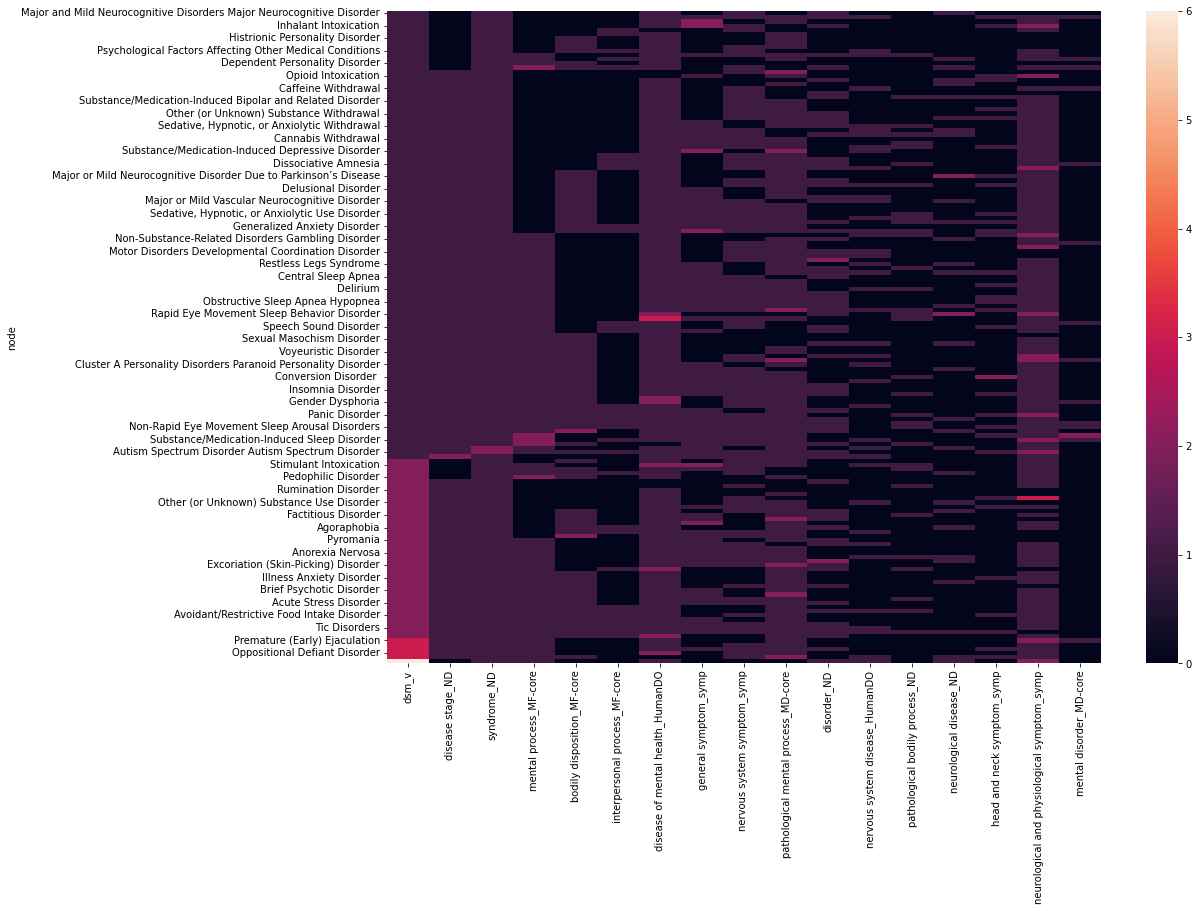

In [12]:
%matplotlib inline
numerical_df = plot_df.iloc[:-1,:-2]

# optional: resize images from now on
plt.rcParams["figure.figsize"] = (16, 12)

# numeric_only_columns is a list of columns of the DataFrame
# containing numerical data only
# annot = True to visualize the correlation factor

sns.heatmap(numerical_df.sort_values(list(numerical_df.columns)))
plt.show()